Load the two profiles (pre-ignition and ignited) with mesa_reader and compare T,rho,X

dt=2.7e-01 s


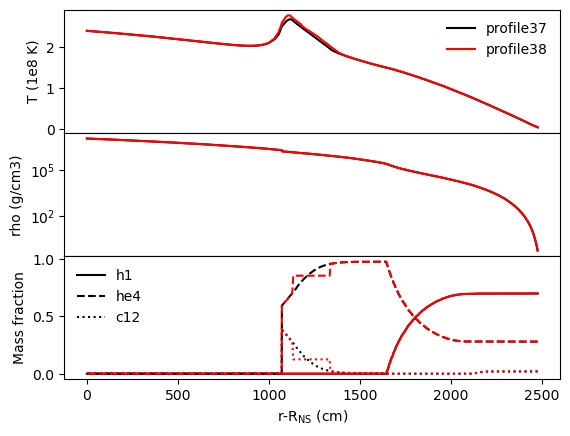

In [16]:
import mesa_reader as mr
import numpy as np
import matplotlib.pyplot as plt

# These were used in the first set of maestro runs for this problem
# They had a fe56 substrate with column y=4.6e10
# prof1 = mr.MesaData("profile46.data")
# prof2 = mr.MesaData("profile47.data")

# These have a smaller substrate, y=5e9
prof1 = mr.MesaData("profile37.data")
prof2 = mr.MesaData("profile38.data")

name1 = prof1.file_name.replace(".data","")
name2 = prof2.file_name.replace(".data","")

yr = 3.1536e7
print(f"dt={(prof2.star_age-prof1.star_age)*yr:.1e} s")

fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
fig.subplots_adjust(hspace=0)

ax1.plot(prof1.R_cm-12e5, prof1.T/1e8, 'k-', label=name1)
ax1.plot(prof2.R_cm-12e5, prof2.T/1e8, 'r-', label=name2)
# ax1.set_ylim([])
ax1.set_ylabel('T (1e8 K)')
ax1.legend(frameon=False)

ax2.semilogy(prof1.R_cm-12e5, prof1.Rho, 'k-')
ax2.semilogy(prof2.R_cm-12e5, prof2.Rho, 'r-')
# ax2.set_ylim([5e5,1e7])
ax2.set_ylabel('rho (g/cm3)')

ax3.plot(prof1.R_cm-12e5, prof1.h1, 'k-', label='h1')
ax3.plot(prof2.R_cm-12e5, prof2.h1, 'r-')

ax3.plot(prof1.R_cm-12e5, prof1.he4, 'k--', label='he4')
ax3.plot(prof2.R_cm-12e5, prof2.he4, 'r--')

ax3.plot(prof1.R_cm-12e5, prof1.c12, 'k:', label='c12')
ax3.plot(prof2.R_cm-12e5, prof2.c12, 'r:')

ax3.set_ylabel('Mass fraction')
ax3.set_xlabel(r'r-R$_{\rm NS}$ (cm)')
ax3.legend(frameon=False,loc=2)

plt.show()

Only a small temperature bump seems necessary to ignite (notice the rapid burn he4->c12)

Check the thin shell instability condition

$$ d\epsilon_{3\alpha}/dT>d\epsilon_{\rm cool}/dT $$

(10.0, 10000000000.0)

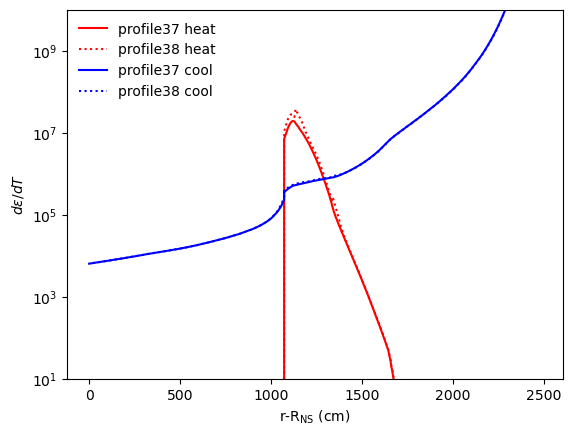

In [18]:
# Constants (cgs)
G = 6.6726e-8
c = 2.99792458e10
arad = 7.5657e-15
Msun = 1.989e33

def dheat_dT(rho,T,Y):
    T9 = T/1e9
    eps_3alpha = 5.1e8 * rho**2 * Y**3 / T9**2 * np.exp(-4.4027/T9) # Hansen & Kawaler Eq. 6.80
    return eps_3alpha / 1e9 * (-3/T9 + 4.4027/T9**2)

g = G*1.4*Msun/12e5**2
# print(g/1e14)

def dcool_dT(T,kappa,y):
    eps_cool = arad*c*T**4 / (3*kappa*y**2)
    return 4*eps_cool/T

plt.figure()
plt.xlabel(r'r-R$_{\rm NS}$ (cm)')
plt.ylabel(r'$d\epsilon/dT$')
plt.semilogy(prof1.R_cm-12e5, dheat_dT(prof1.Rho,prof1.T,prof1.he4), 'r-', label=f'{name1} heat')
plt.semilogy(prof2.R_cm-12e5, dheat_dT(prof2.Rho,prof2.T,prof2.he4), 'r:', label=f'{name2} heat')

plt.semilogy(prof1.R_cm-12e5, dcool_dT(prof1.T,prof1.opacity,prof1.column_depth), 'b-', label=f'{name1} cool')
plt.semilogy(prof2.R_cm-12e5, dcool_dT(prof2.T,prof2.opacity,prof2.column_depth), 'b:', label=f'{name2} cool')

plt.legend(frameon=False)

plt.ylim([1e1,1e10])

Both models are past the thin shell instability, but note that this underestimates the cooling rate as it doesn't consider convection.

Maestro applies a temperature perturbation at the beginning of the run, see `MaestroInitData.cpp`. We reproduce this here to see the effect.

Text(0, 0.5, 'T (1e8 K)')

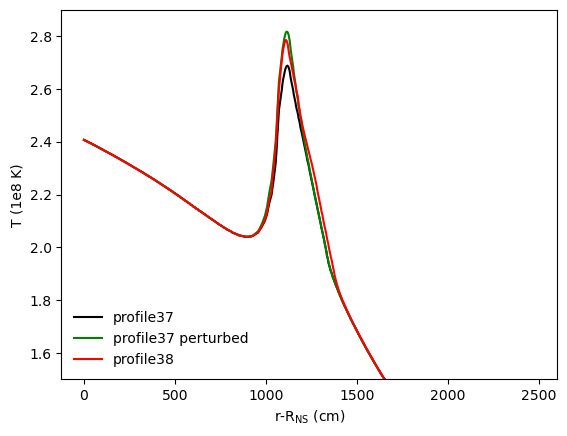

In [21]:
# Values set in inputs_2d

# for profile 46
# xrb_pert_size = 15
# # xrb_pert_factor = 1.0e-5
# xrb_pert_factor = 5.0e-2
# # xrb_pert_type = 1 # this just means temperature pert not density
# xrb_pert_height = 2000.0

xrb_pert_size = 15
# xrb_pert_factor = 1.0e-5
xrb_pert_factor = 5.0e-2
# xrb_pert_type = 1 # this just means temperature pert not density
xrb_pert_height = 1100.0

rad_pert = -xrb_pert_size**2/(4*np.log(0.5))

# Note in the code the perturbation is 2D, i.e. depends on x. Here we just model at x=0
y = prof1.R_cm-12e5 - xrb_pert_height
Tnew = prof1.T * (1 + xrb_pert_factor * np.exp(-y**2/rad_pert**2))

plt.figure()
plt.plot(prof1.R_cm-12e5, prof1.T/1e8, 'k-', label=name1)
plt.plot(prof1.R_cm-12e5, Tnew/1e8, 'g-', label=f'{name1} perturbed')
plt.plot(prof2.R_cm-12e5, prof2.T/1e8, 'r-', label=name2)
plt.ylim([1.5,2.9])
plt.legend(frameon=False,loc=3)
plt.xlabel(r'r-R$_{\rm NS}$ (cm)')
plt.ylabel(r'T (1e8 K)')